# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
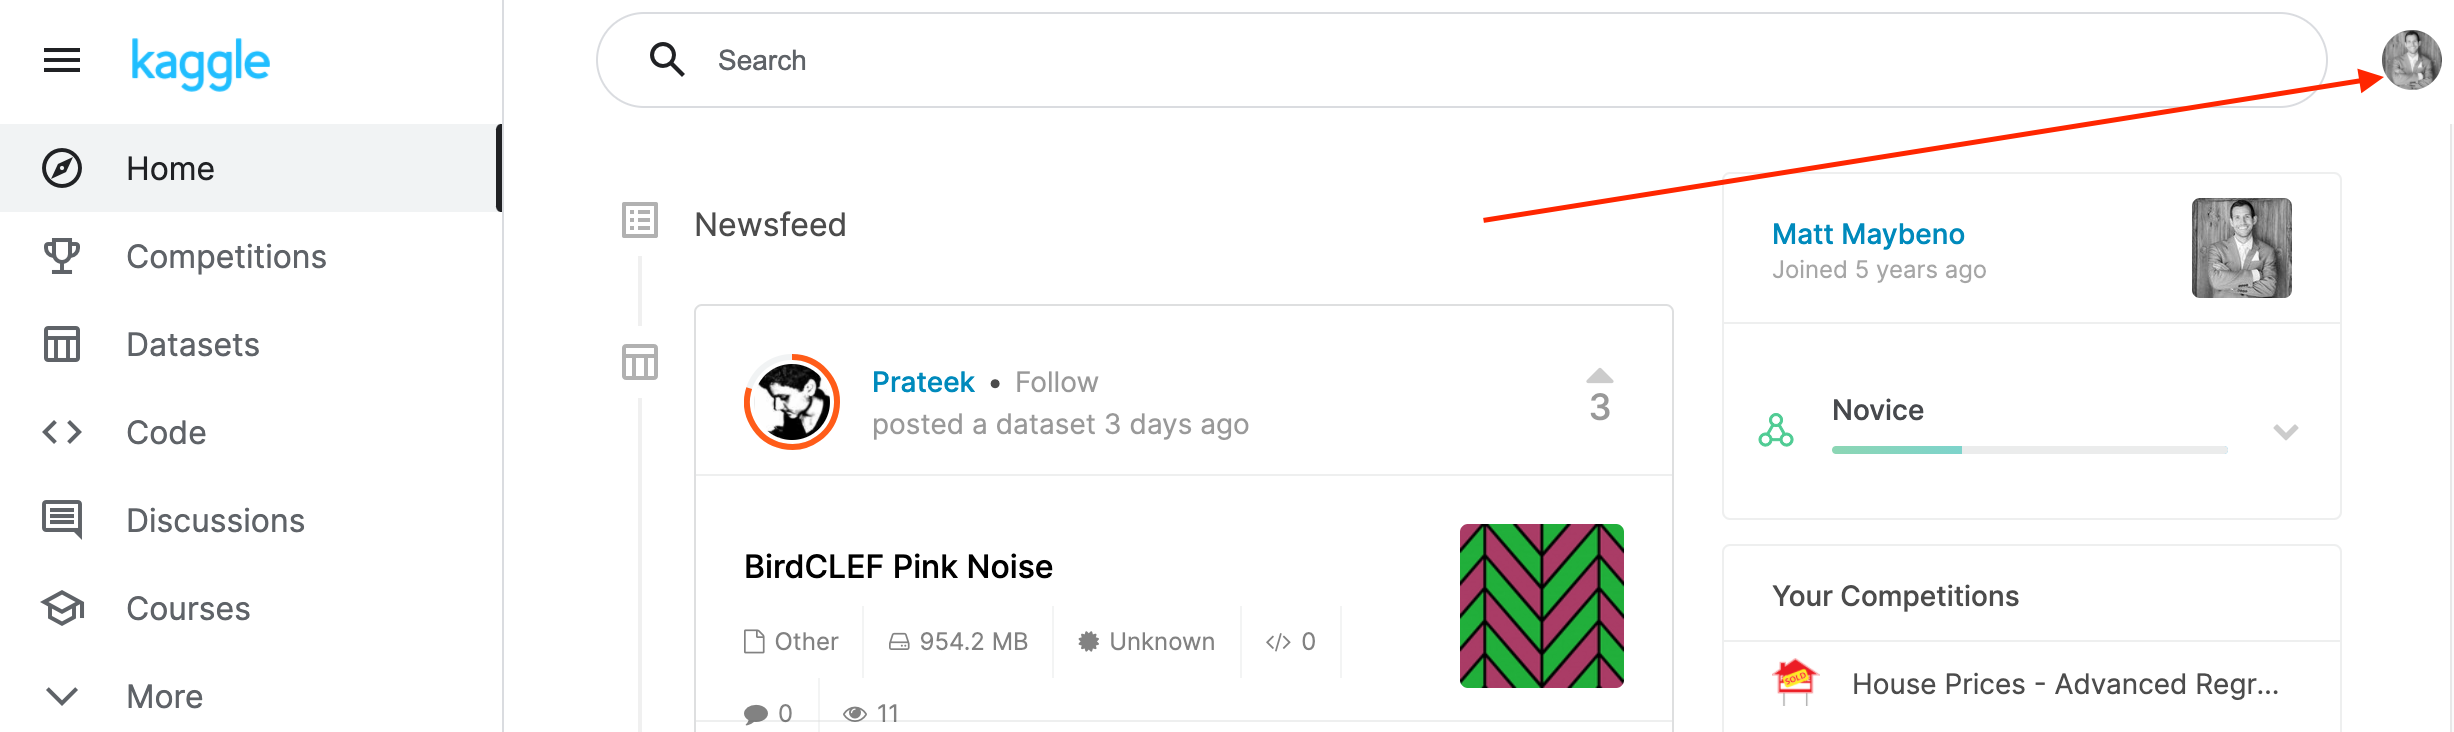
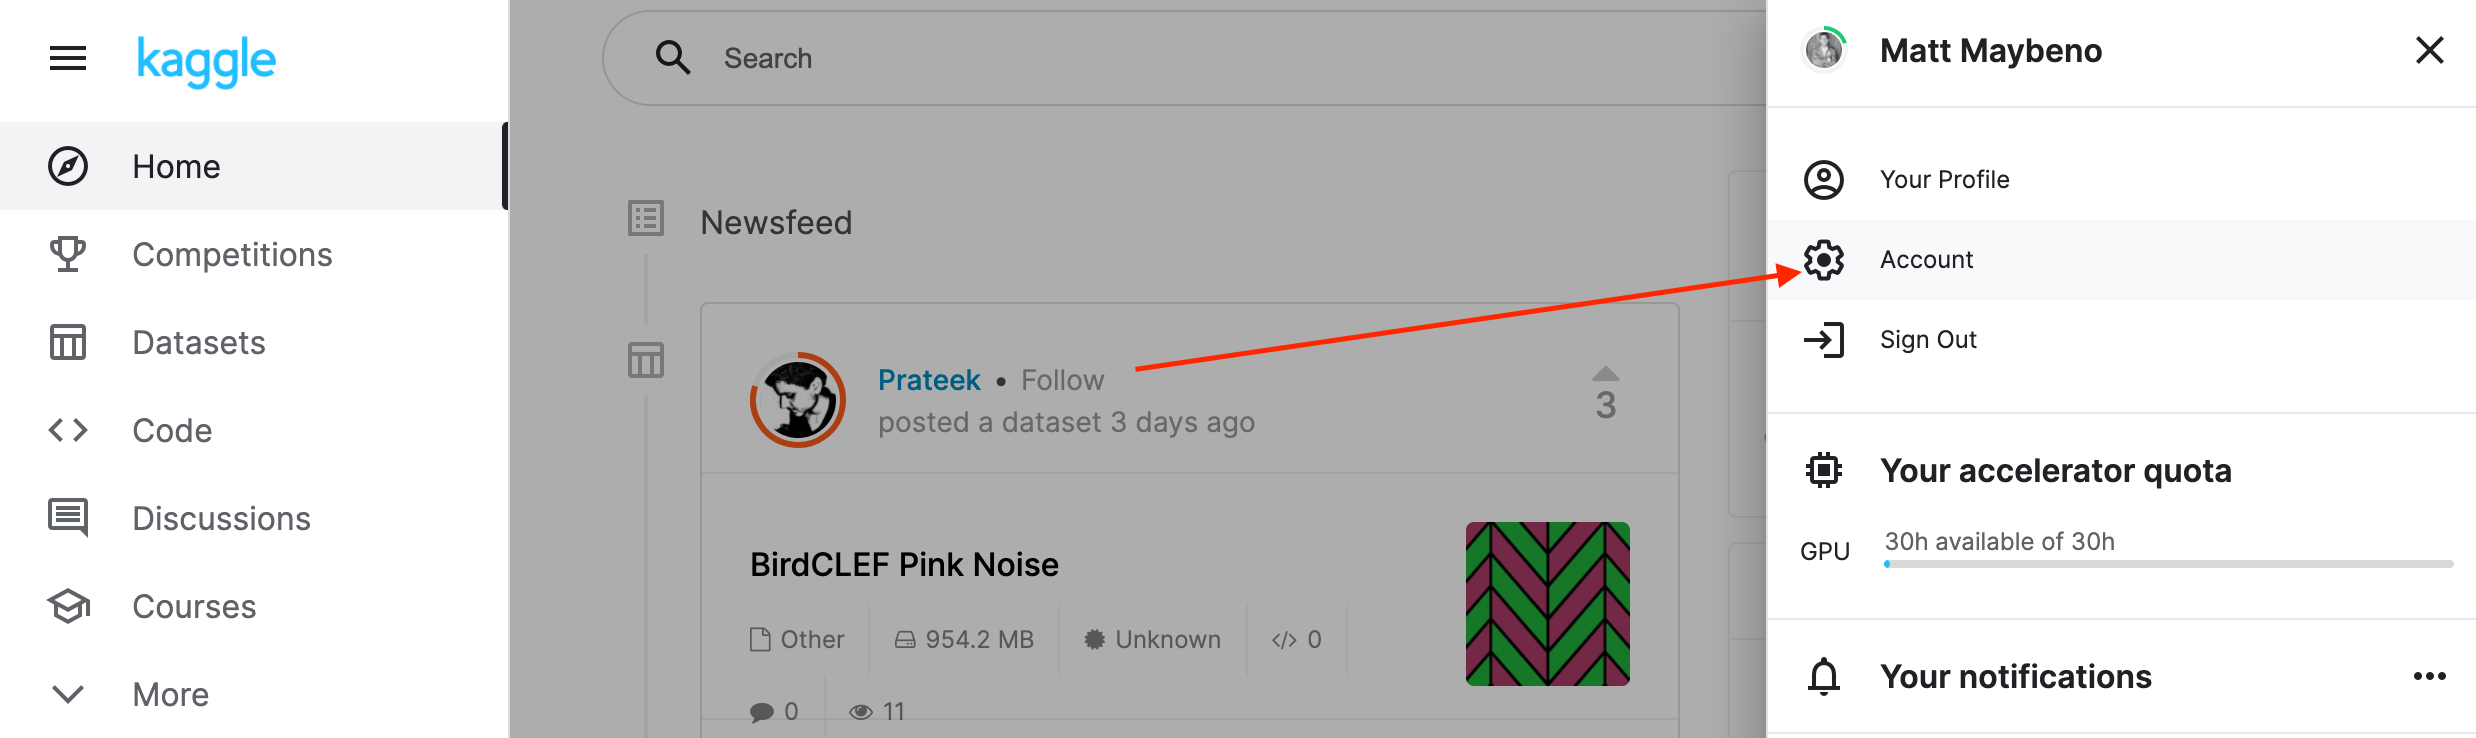
2. Scroll down to API and click Create New API Token.
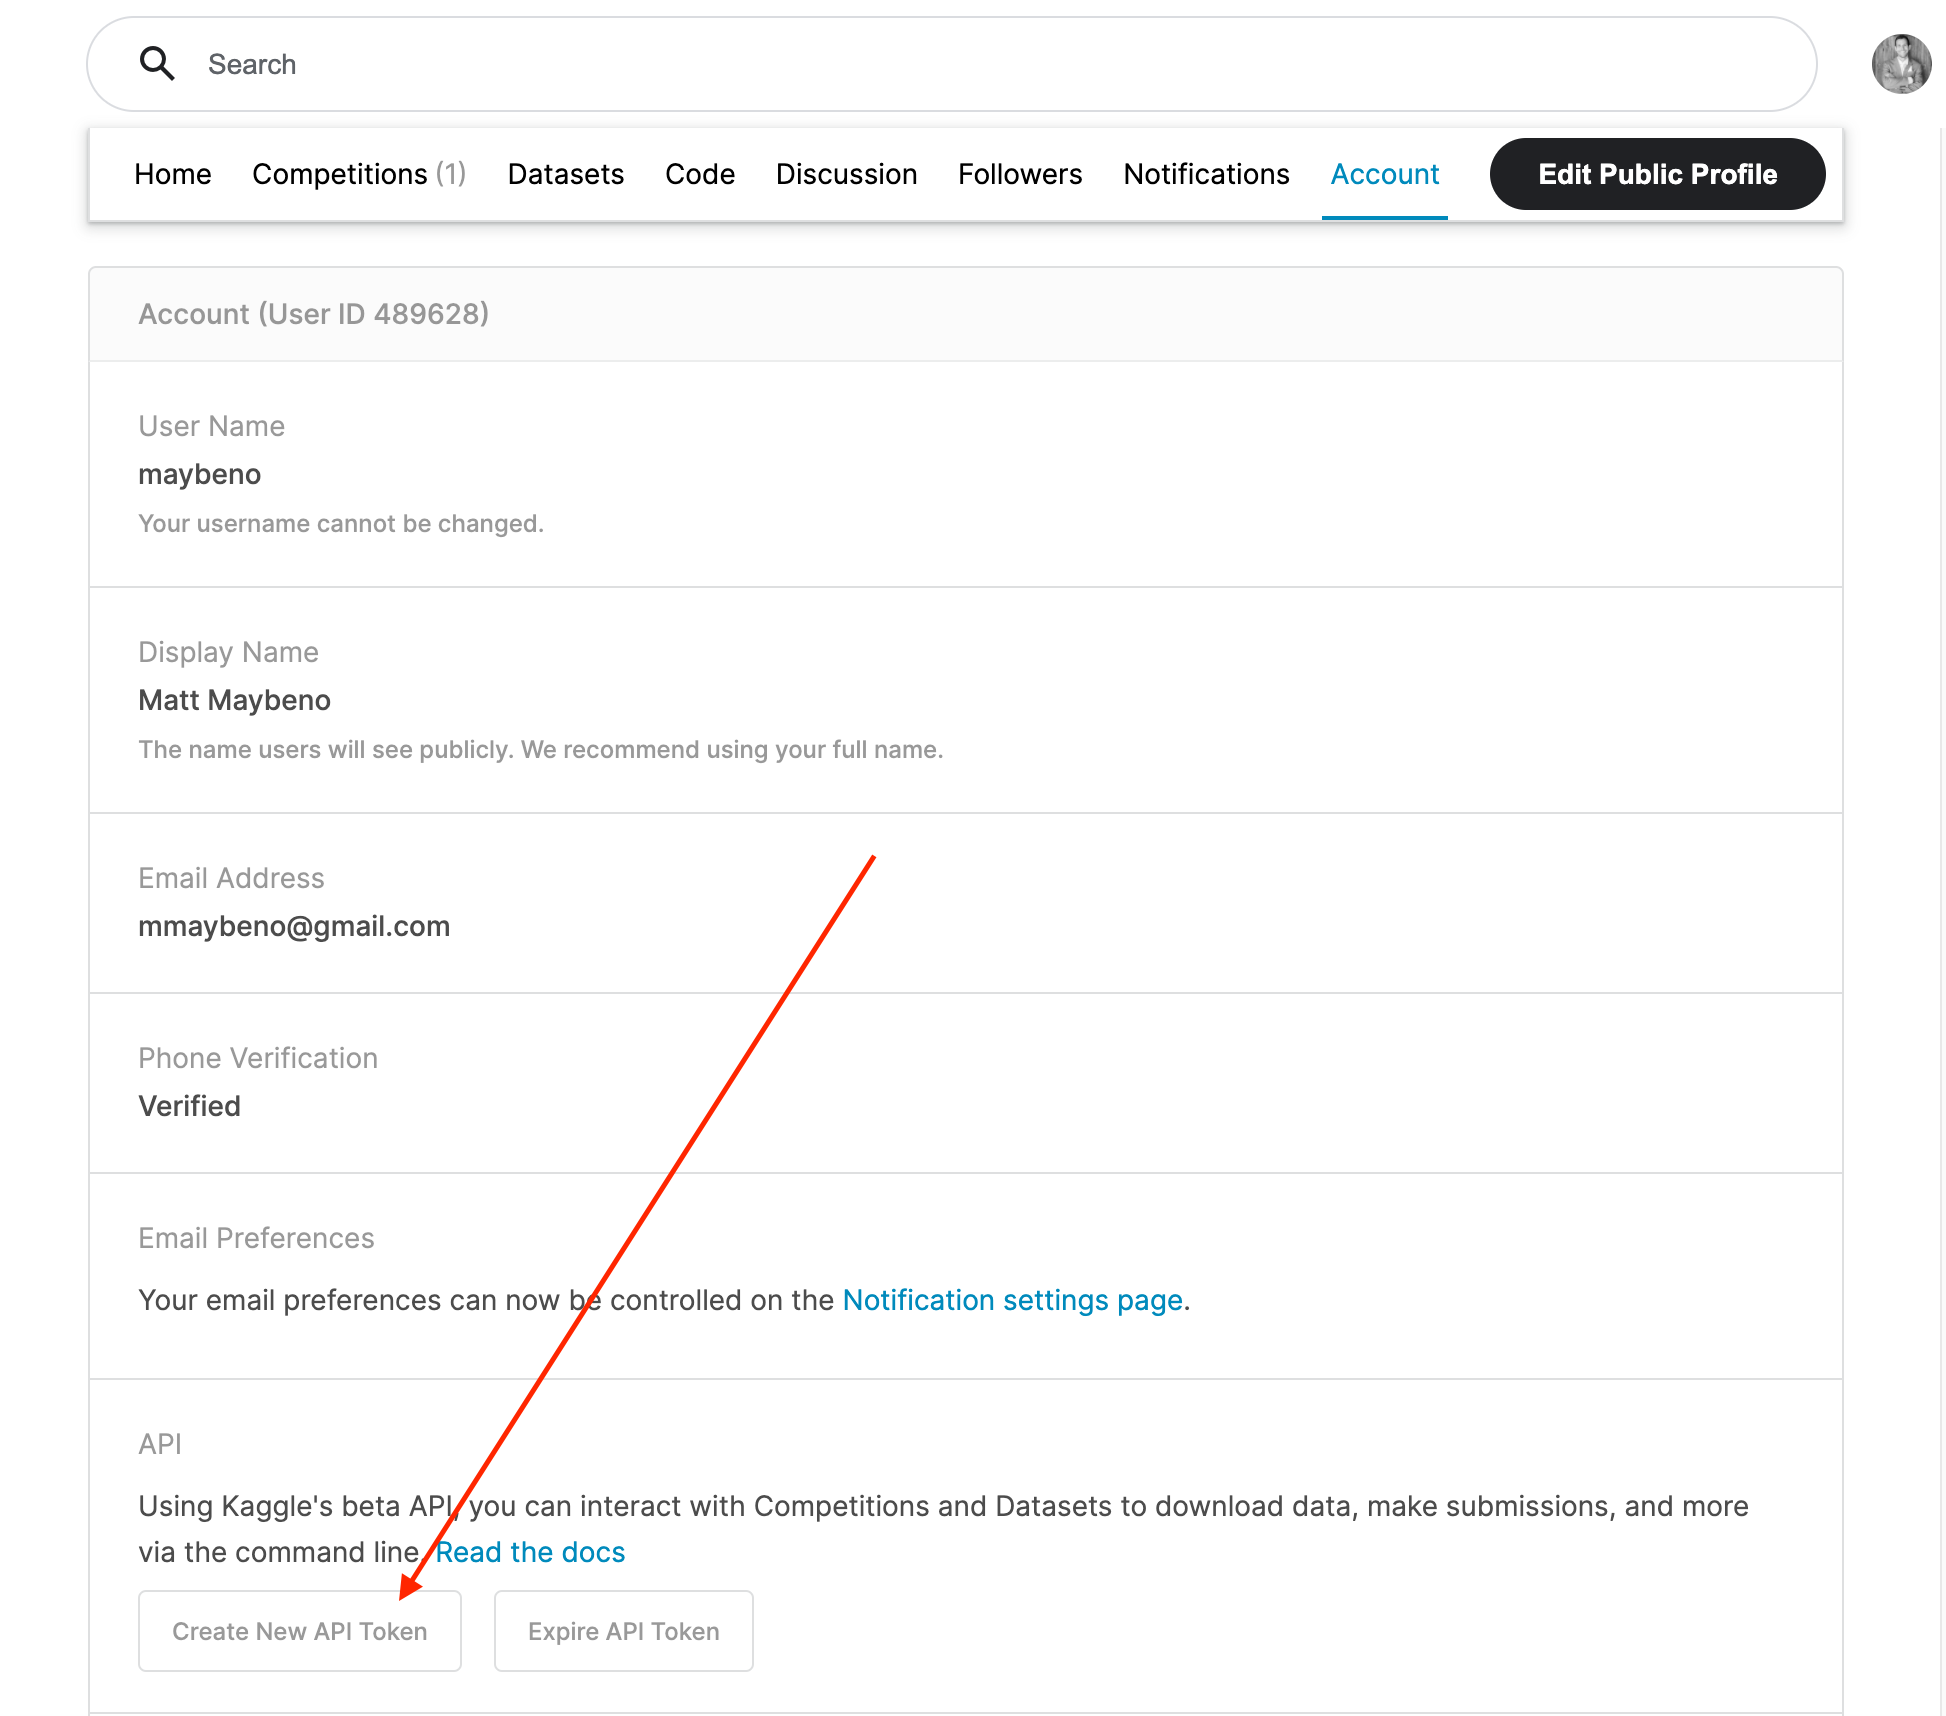
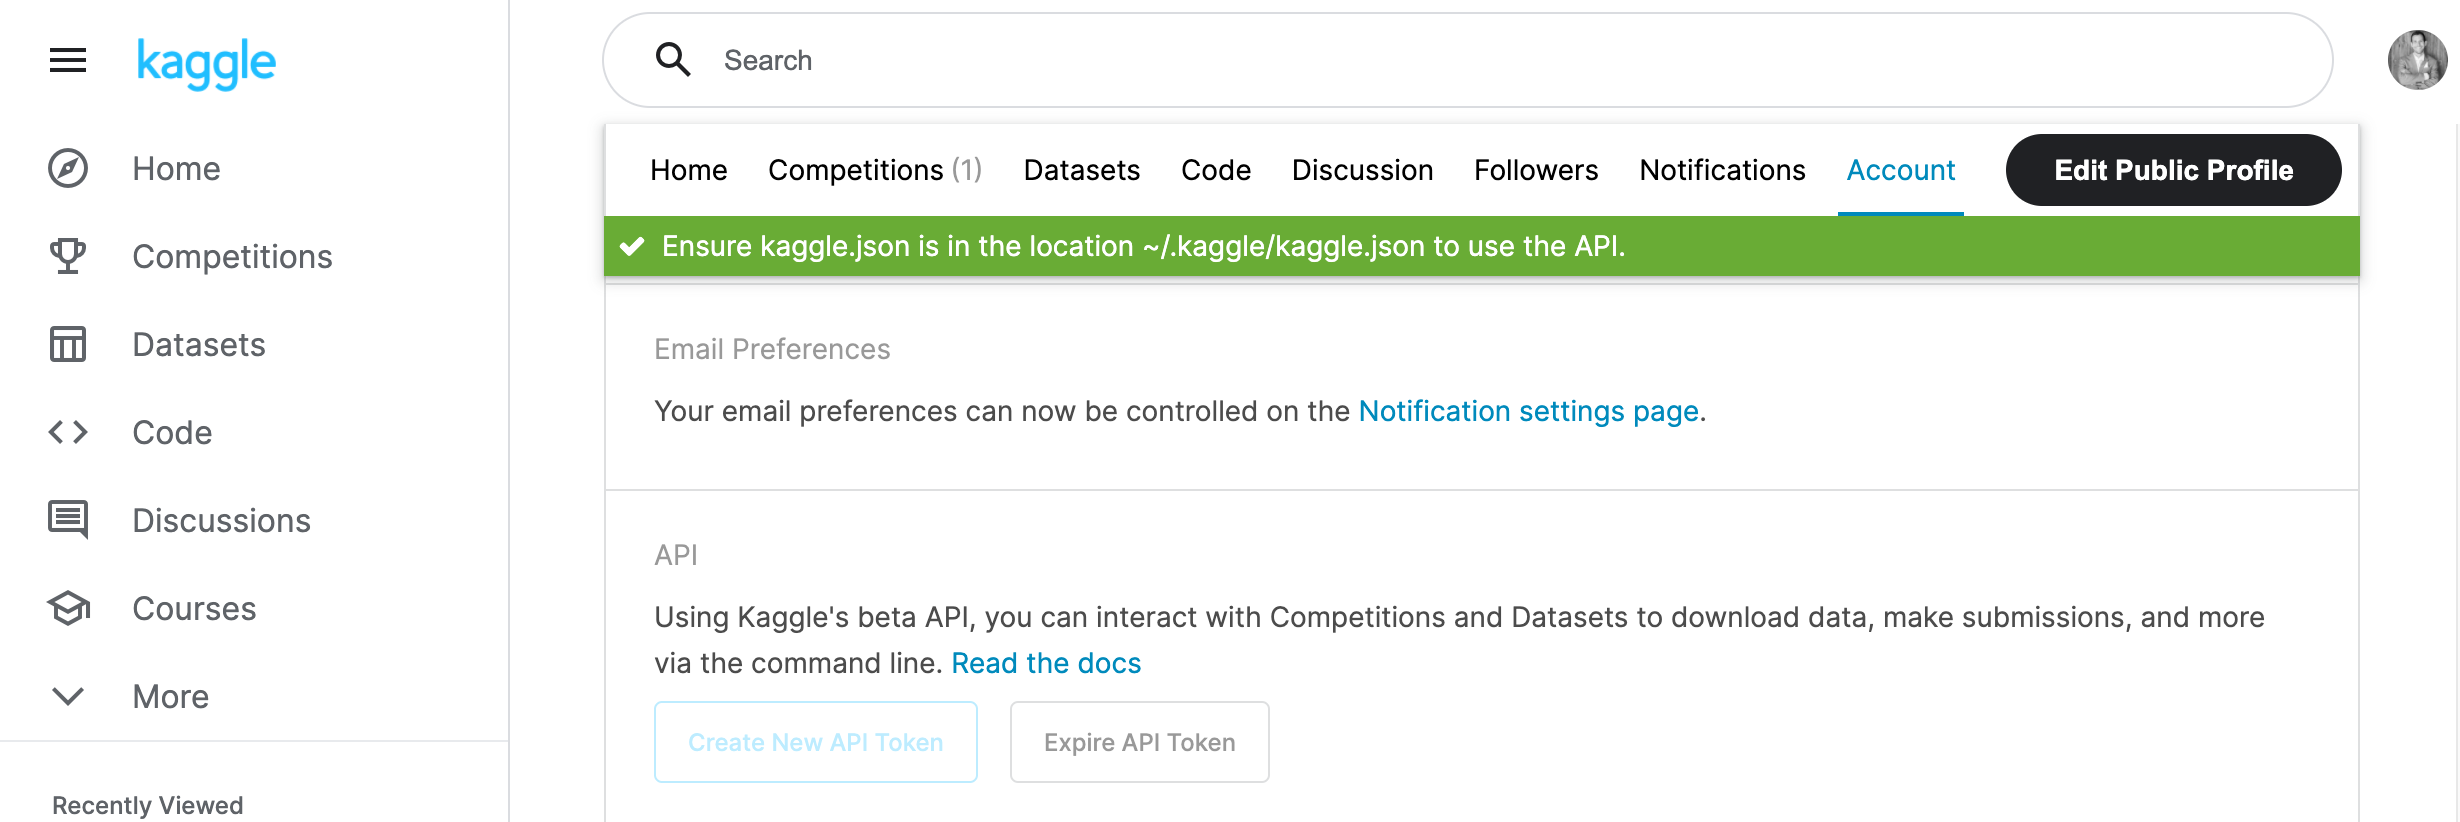
3. Open up `kaggle.json` and use the username and key.
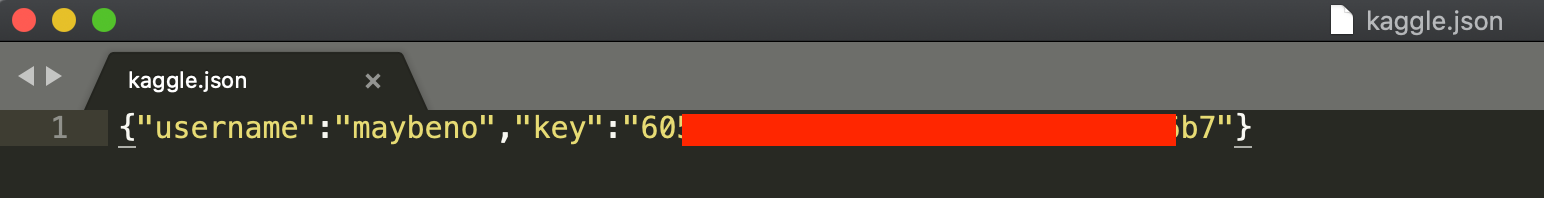

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached pip-23.3.2-py3-none-any.whl.metadata (3.5 kB)
Using cached pip-23.3.2-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1
  Using cached setuptools-69.0.3-py3-none-any.whl.metadata (6.3 kB)
  Using cached wheel-0.42.0-py3-none-any.whl.metadata (2.2 kB)
Using cached setuptools-69.0.3-py3-none-any.whl (819 kB)
Using cached wheel-0.42.0-py3-none-any.whl (65 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.41.3
    Uninstalling wheel-0.41.3:
      Successfully uninstalled wheel-0.41.3
  Attempting uninstall: setuptools
    Found existing installation: setuptools 68.2.2
    Uninstalling setuptools-68.2.2:
      Successfully uninstalled setuptools-68.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dash 2.14.

### Setup Kaggle API Key

In [2]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /home/sagemaker-user/.kaggle
!touch /home/sagemaker-user/.kaggle/kaggle.json
!chmod 600 /home/sagemaker-user/.kaggle/kaggle.json

In [3]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "jatinbajaj007"
kaggle_key = "b289cee5c9f55216dc025a86b88f3431"

# Save API token the kaggle.json file
with open("/home/sagemaker-user/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
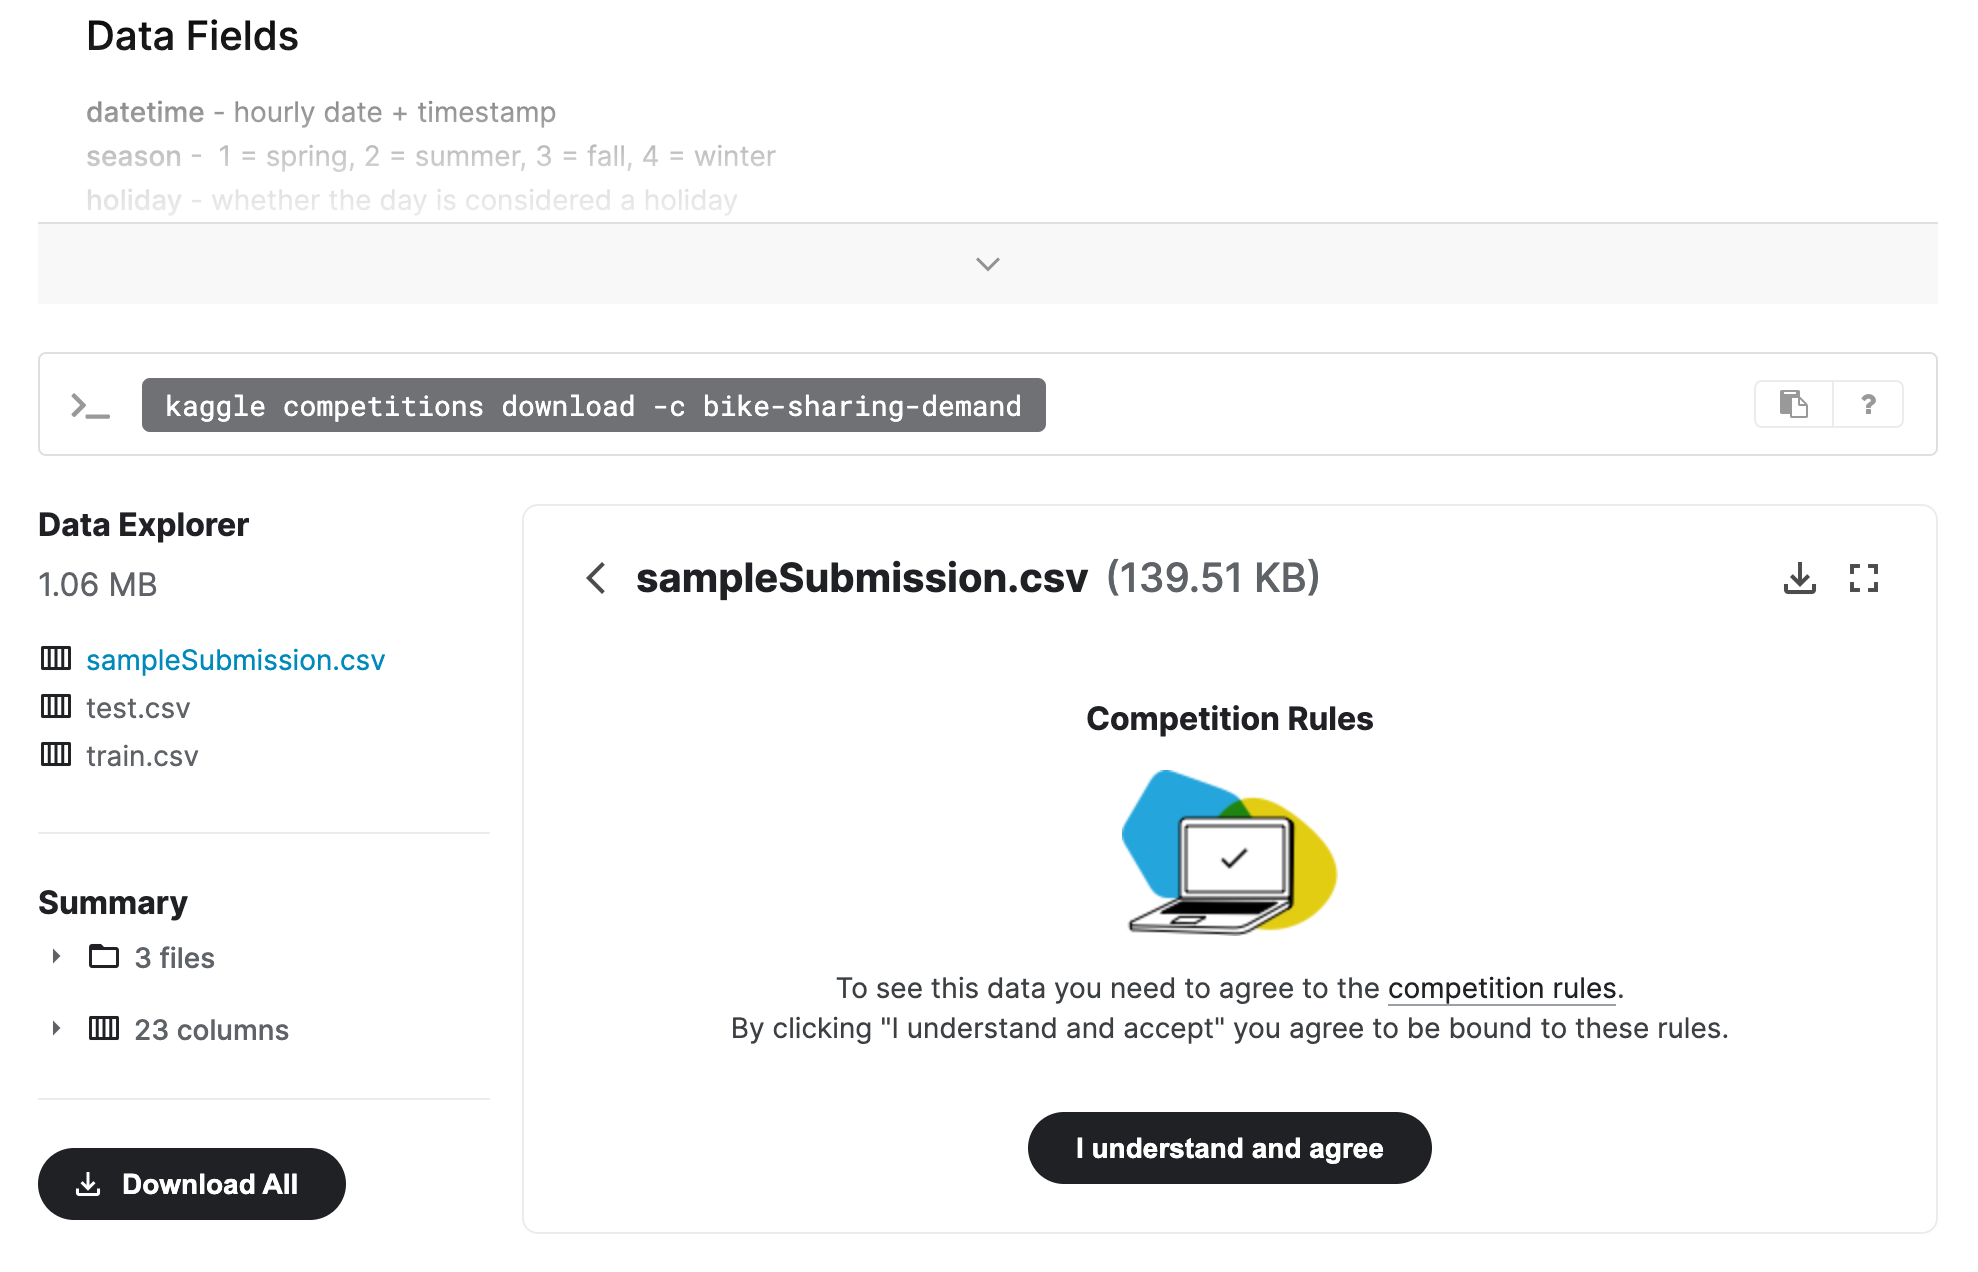

In [4]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!pip install kaggle --upgrade
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  Using cached kaggle-1.6.3-py3-none-any.whl
bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [6]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv")
train['datetime'] = pd.to_datetime(train['datetime'])
train['date'] = train['datetime'].dt.date
train['hour'] = train['datetime'].dt.hour
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,4


In [7]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838


In [8]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv")
test['datetime'] = pd.to_datetime(test['datetime'])
test['date'] = test['datetime'].dt.date
test['hour'] = test['datetime'].dt.hour


In [9]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011-01-20,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011-01-20,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011-01-20,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011-01-20,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011-01-20,4


In [10]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [10]:
train_dataset=train.drop(columns =['casual','registered'],axis=1)
predictor = TabularPredictor(label="count",eval_metric="root_mean_squared_error").fit(train_data=train_dataset,time_limit=600,presets="best_quality",auto_stack=False,num_bag_folds=0)

No path specified. Models will be saved in: "AutogluonModels/ag-20240125_112140"
Presets specified: ['best_quality']
/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240125_112140"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jan 2 17:47:37 UTC 2024
Disk Space Avail:   4.97 GB / 5.36 GB (92.8%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/util

[1000]	valid_set's rmse: 38.4121
[2000]	valid_set's rmse: 36.2968
[3000]	valid_set's rmse: 35.779
[4000]	valid_set's rmse: 35.5113
[5000]	valid_set's rmse: 35.4152
[6000]	valid_set's rmse: 35.4099
[7000]	valid_set's rmse: 35.4528


	-35.388	 = Validation score   (-root_mean_squared_error)
	11.19s	 = Training   runtime
	1.06s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 583.07s of the 583.07s of remaining time.


[1000]	valid_set's rmse: 36.1794


	-36.0576	 = Validation score   (-root_mean_squared_error)
	1.62s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 581.15s of the 581.15s of remaining time.
	-38.568	 = Validation score   (-root_mean_squared_error)
	18.28s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 562.17s of the 562.16s of remaining time.
	-34.667	 = Validation score   (-root_mean_squared_error)
	85.53s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 476.6s of the 476.6s of remaining time.
	-39.7619	 = Validation score   (-root_mean_squared_error)
	8.05s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 467.84s of the 467.84s of remaining time.
	-44.8724	 = Validation score   (-root_mean_squared_error)
	14.87s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGB

### Review AutoGluon's training run with ranking of models that did the best.

In [11]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -32.578146       1.652007  202.935031                0.000451           0.293557            2       True         12
1         LightGBMLarge  -34.127384       0.135125    3.284047                0.135125           3.284047            1       True         11
2              CatBoost  -34.666996       0.011169   85.529072                0.011169          85.529072            1       True          6
3            LightGBMXT  -35.387988       1.056448   11.187072                1.056448          11.187072            1       True          3
4               XGBoost  -36.003728       0.151096    5.042647                0.151096           5.042647            1       True          9
5              LightGBM  -36.057558       0.121543    1.618152                0.121543      

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': -123.67450390933168,
  'KNeighborsDist': -99.50984744008632,
  'LightGBMXT': -35.38798837266742,
  'LightGBM': -36.05755849586654,
  'RandomForestMSE': -38.56802751160794,
  'CatBoost': -34.66699583704852,
  'ExtraTreesMSE': -39.76191385761545,
  'NeuralNetFastAI': -44.872425139309364,
  'XGBoost': -36.003728160365476,
  'NeuralNetTorch': -39.63000329563728,
  'LightGBMLarge': -34.12738390992768,
  'WeightedEnsemble_L2': -32.57814591523264},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': ['KNeigh

In [ ]:
predictor.feature_importance(data=train_dataset)

### Create predictions from test dataset

In [12]:
predictions = predictor.predict(test)
predictions.head()

/opt/conda/lib/python3.10/site-packages/autogluon/features/generators/fillna.py:58: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X.fillna(self._fillna_feature_map, inplace=True, downcast=False)


0    10.644296
1     0.199757
2    -1.924678
3     0.230864
4     1.615159
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [13]:
# Describe the `predictions` series to see if there are any negative values
predictions_df = pd.DataFrame(predictions,columns=['count'])
predictions_df.head()

,count
0,10.644296
1,0.199757
2,-1.924678
3,0.230864
4,1.615159


In [15]:
# How many negative values do we have?
(predictions_df < 0).any().any()

True

In [18]:
# Set them to zero
predictions_df=predictions_df.mask(predictions_df < 0, 0)
(predictions_df < 0).any().any()

False

### Set predictions to submission dataframe, save, and submit

In [20]:
submission["count"] = predictions_df ["count"]
submission.to_csv("submission.csv", index=False)

In [21]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 364kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [22]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2024-01-25 11:28:56  first raw submission               complete  0.52772      0.52772       
submission_new_hpo.csv       2024-01-25 08:11:55  new features with hyperparameters  complete  0.58263      0.58263       
submission_new_hpo.csv       2024-01-25 07:49:08  new features with hyperparameters  complete  0.58263      0.58263       
submission_new_hpo.csv       2024-01-25 07:40:03  new features with hyperparameters  complete  0.58263      0.58263       


#### Initial score of `?`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>],
       [<Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>],
       [<Axes: title={'center': 'hour'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

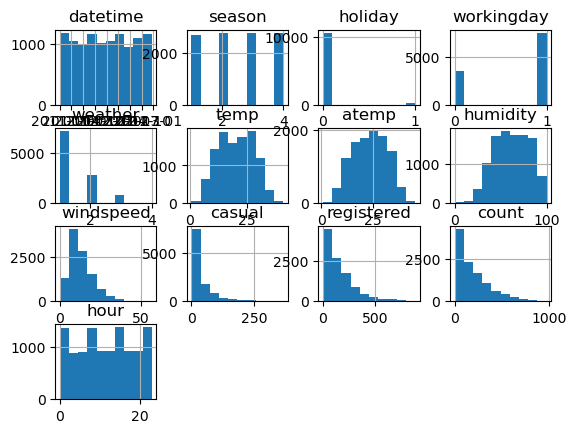

In [11]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [16]:
import numpy as np

In [17]:
# create a new feature
train['humid'] = np.where(train['humidity']>75 ,"Very humid","Not humid")
train['windy'] = np.where(train['windspeed'] > 10, "Windy","Not Windy")
test['humid'] = np.where(test['humidity']>75 ,"Very humid","Not humid")
test['windy'] = np.where(test['windspeed'] > 10, "Windy","Not Windy")

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [14]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [15]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,4


(array([455., 454., 448., 433., 442., 452., 455., 455., 455., 455., 455.,
        455., 456., 456., 456., 456., 456., 456., 456., 456., 456., 456.,
        456., 456.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 <BarContainer object of 24 artists>)

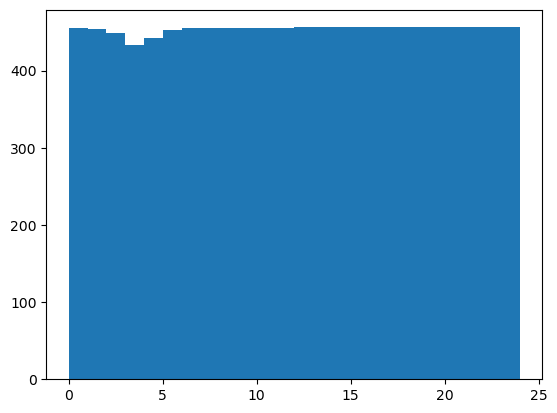

In [18]:
# View histogram of all features again now with the hour feature
import matplotlib.pyplot as plt

plt.hist(train['hour'], bins=range(0, 25))

## Step 5: Rerun the model with the same settings as before, just with more features

In [27]:
train_dataset_newfeatures=train.drop(columns =['casual','registered'],axis=1)
predictor_new_features = TabularPredictor(label="count",eval_metric="root_mean_squared_error").fit(train_data=train_dataset_newfeatures,time_limit=600,
    presets="best_quality",auto_stack=False,num_bag_folds=0)

No path specified. Models will be saved in: "AutogluonModels/ag-20240125_113042"
Presets specified: ['best_quality']
/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240125_113042"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jan 2 17:47:37 UTC 2024
Disk Space Avail:   4.42 GB / 5.36 GB (82.5%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/util

[1000]	valid_set's rmse: 38.6506
[2000]	valid_set's rmse: 37.024
[3000]	valid_set's rmse: 36.8885
[4000]	valid_set's rmse: 36.9227


	-36.7908	 = Validation score   (-root_mean_squared_error)
	8.2s	 = Training   runtime
	0.85s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 588.73s of the 588.73s of remaining time.
	-35.317	 = Validation score   (-root_mean_squared_error)
	1.35s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 587.2s of the 587.19s of remaining time.
	-38.7427	 = Validation score   (-root_mean_squared_error)
	18.64s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 567.9s of the 567.9s of remaining time.
	-35.5516	 = Validation score   (-root_mean_squared_error)
	152.3s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 415.54s of the 415.53s of remaining time.
	-40.6464	 = Validation score   (-root_mean_squared_error)
	9.19s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: NeuralNetFa

In [28]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -32.419317       1.349403  257.027525                0.000483           0.351614            2       True         12
1         LightGBMLarge  -33.109372       0.175444    3.369318                0.175444           3.369318            1       True         11
2              LightGBM  -35.317049       0.066125    1.354569                0.066125           1.354569            1       True          4
3              CatBoost  -35.551647       0.020019  152.303011                0.020019         152.303011            1       True          6
4               XGBoost  -35.818021       0.170989    4.672428                0.170989           4.672428            1       True          9
5            LightGBMXT  -36.790819       0.853508    8.197156                0.853508      

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': -123.67450390933168,
  'KNeighborsDist': -99.50984744008632,
  'LightGBMXT': -36.79081866048818,
  'LightGBM': -35.31704919614282,
  'RandomForestMSE': -38.74271431582594,
  'CatBoost': -35.551646801830046,
  'ExtraTreesMSE': -40.64639744838351,
  'NeuralNetFastAI': -44.974863776197154,
  'XGBoost': -35.81802108942975,
  'NeuralNetTorch': -40.18896199391339,
  'LightGBMLarge': -33.109372065506896,
  'WeightedEnsemble_L2': -32.41931704302756},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': ['KNeig

In [29]:
predictions_new_features = predictor_new_features.predict(test)

/opt/conda/lib/python3.10/site-packages/autogluon/features/generators/fillna.py:58: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X.fillna(self._fillna_feature_map, inplace=True, downcast=False)


In [30]:
# Remember to set all negative values to zero
predictions_new_features_df = pd.DataFrame(predictions_new_features,columns=['count'])
predictions_new_features_df.head()
predictions_new_features_df=predictions_new_features_df.mask(predictions_new_features_df < 0, 0)
(predictions_new_features_df < 0).any().any()

False

In [31]:
# Same submitting predictions'
submission_new_features=pd.read_csv("sampleSubmission.csv")
submission_new_features["count"] = predictions_new_features_df['count']
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [32]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 409kB/s]
Successfully submitted to Bike Sharing Demand

In [33]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-01-25 11:48:35  new features                       complete  0.51745      0.51745       
submission.csv               2024-01-25 11:28:56  first raw submission               complete  0.52772      0.52772       
submission_new_hpo.csv       2024-01-25 08:11:55  new features with hyperparameters  complete  0.58263      0.58263       
submission_new_hpo.csv       2024-01-25 07:49:08  new features with hyperparameters  complete  0.58263      0.58263       


#### New Score of `?`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [43]:
gbm_options = { 
    'num_boost_round': 100,
    'learning_rate':0.4,
    'num_leaves':100
}
hyperparameters= {
     'GBM': gbm_options,
}


hyperparameter_tune_kwargs = {
    'num_trails': 6,
    'scheduler':'local',
    'searcher':'auto'
}

In [44]:
train_dataset_newfeatures=train.drop(columns =['casual','registered'],axis=1)
predictor_new_hpo = TabularPredictor(label="count",eval_metric="root_mean_squared_error").fit(train_data=train_dataset_newfeatures,time_limit=600,
    presets="best_quality",auto_stack=False,save_space=True,hyperparameters=hyperparameters,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,)


No path specified. Models will be saved in: "AutogluonModels/ag-20240130_075356"
Presets specified: ['best_quality']
/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240130_075356"
AutoGluon Version:  0.8.2
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jan 2 17:47:37 UTC 2024
Disk Space Avail:   4.47 GB / 5.36 GB (83.5%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/util

In [45]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                   model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0          LightGBM/T346 -37.091992       0.015012  0.439893                0.015012           0.439893            1       True        346
1    WeightedEnsemble_L2 -37.091992       0.015419  0.598088                0.000408           0.158195            2       True        838
2           LightGBM/T11 -37.091992       0.015894  0.549057                0.015894           0.549057            1       True         11
3          LightGBM/T239 -37.091992       0.015983  0.488293                0.015983           0.488293            1       True        239
4          LightGBM/T105 -37.091992       0.016074  0.533521                0.016074           0.533521            1       True        105
5          LightGBM/T671 -37.091992       0.017303  0.684024                0.017303           0.684024 

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBM/T1': 'LGBModel',
  'LightGBM/T2': 'LGBModel',
  'LightGBM/T3': 'LGBModel',
  'LightGBM/T4': 'LGBModel',
  'LightGBM/T5': 'LGBModel',
  'LightGBM/T6': 'LGBModel',
  'LightGBM/T7': 'LGBModel',
  'LightGBM/T8': 'LGBModel',
  'LightGBM/T9': 'LGBModel',
  'LightGBM/T10': 'LGBModel',
  'LightGBM/T11': 'LGBModel',
  'LightGBM/T12': 'LGBModel',
  'LightGBM/T13': 'LGBModel',
  'LightGBM/T14': 'LGBModel',
  'LightGBM/T15': 'LGBModel',
  'LightGBM/T16': 'LGBModel',
  'LightGBM/T17': 'LGBModel',
  'LightGBM/T18': 'LGBModel',
  'LightGBM/T19': 'LGBModel',
  'LightGBM/T20': 'LGBModel',
  'LightGBM/T21': 'LGBModel',
  'LightGBM/T22': 'LGBModel',
  'LightGBM/T23': 'LGBModel',
  'LightGBM/T24': 'LGBModel',
  'LightGBM/T25': 'LGBModel',
  'LightGBM/T26': 'LGBModel',
  'LightGBM/T27': 'LGBModel',
  'LightGBM/T28': 'LGBModel',
  'LightGBM/T29': 'LGBModel',
  'LightGBM/T30': 'LGBModel',
  'LightGBM/T31': 'LGBModel',
  'LightGBM/T32': 'LGBModel',
  'LightGBM/T33': 'LGBModel',
  'L

In [46]:
# Remember to set all negative values to zero
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo_df = pd.DataFrame(predictions_new_hpo,columns=['count'])
predictions_new_hpo_df.head()
(predictions_new_hpo_df < 0).any().any()

/opt/conda/lib/python3.10/site-packages/autogluon/features/generators/fillna.py:58: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  X.fillna(self._fillna_feature_map, inplace=True, downcast=False)


True

In [47]:
predictions_new_hpo_df=predictions_new_hpo_df.mask(predictions_new_hpo_df < 0, 0)
(predictions_new_hpo_df < 0).any().any()

False

In [49]:
# Same submitting predictions
submission_new_hpo=pd.read_csv("sampleSubmission.csv")
submission_new_hpo["count"] = predictions_new_hpo_df["count"]
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [50]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 187k/187k [00:00<00:00, 389kB/s]
Successfully submitted to Bike Sharing Demand

In [51]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-01-30 08:05:50  new features with hyperparameters  complete  0.61257      0.61257       
submission_new_hpo.csv       2024-01-30 07:49:10  new features with hyperparameters  complete  0.58843      0.58843       
submission_new_hpo.csv       2024-01-26 08:19:40  new features with hyperparameters  complete  0.51745      0.51745       
submission_new_features.csv  2024-01-25 11:48:35  new features                       complete  0.51745      0.51745       


#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

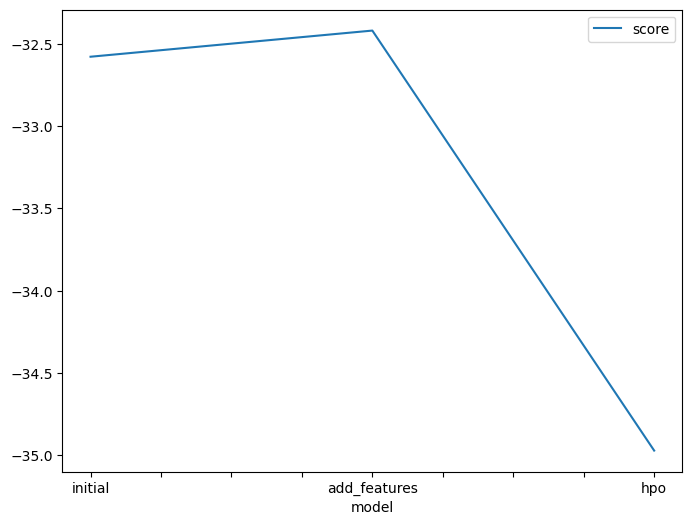

In [42]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-32.578146,-32.419317 , -34.970947 ]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

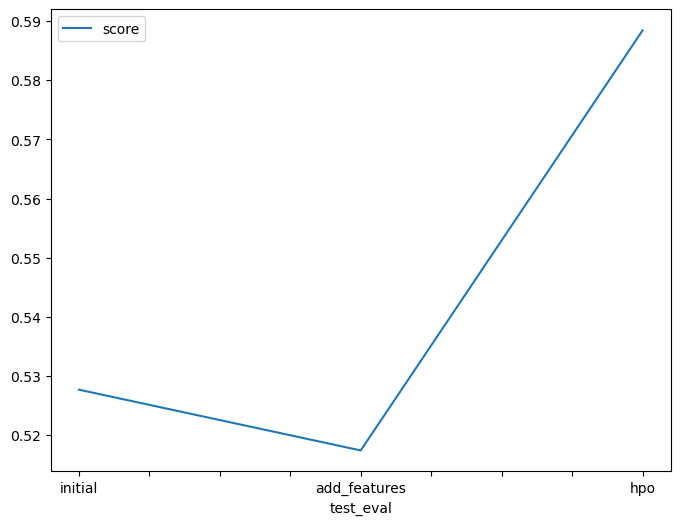

In [41]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [0.52772, 0.51745, 0.58843]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [0.52772, 0.51745, 0.58843],
    "hpo2": [0.52772, 0.51745, ?],
    "hpo3": [0.52772, 0.51745, ?],
    "score": [0.52772, 0.51745, ?]
})